In [1]:
# Cell 1: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# Optional: display settings
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Cell 2: define columns and structure
columns = [
    'store_id',          # unique store identifier
    'month',             # month of record
    'year',              # year of record

    # sales and profit
    'units_sold',        # number of jars/tins sold
    'revenue_usd',       # total sales revenue
    'cost_usd',          # cost of goods sold
    'gross_profit_usd',  # revenue - cost
    'gross_margin_pct',  # gross profit as percent of revenue

    # store local demographics
    'median_income',     # median household income in store area
    'population',        # population of store neighborhood or zip
    'percent_age_18_34', # percent of population 18–34 years
    'percent_age_35_64', # percent 35–64
    'percent_age_65_plus' # percent 65+
]

In [3]:
# Cell 3: parameters for synthetic dataset
n_stores = 50
months = pd.date_range(start='2024-01-01', periods=12, freq='MS')

# Create store IDs
store_ids = [f'S{str(i).zfill(3)}' for i in range(1, n_stores + 1)]

# Helper to create demographics per store (static across months)
demographics = pd.DataFrame({
    'store_id': store_ids,
    'median_income': np.random.normal(loc=50000, scale=10000, size=n_stores).clip(30000, 100000),
    'population': np.random.normal(loc=20000, scale=5000, size=n_stores).clip(5000, 50000).astype(int),
    # create age distributions that sum to ~100%
    'percent_age_18_34': np.random.uniform(0.2, 0.4, size=n_stores),
    'percent_age_35_64': np.random.uniform(0.4, 0.6, size=n_stores)
})
# ensure percentages sum to <=1, remainder goes to 65+
demographics['percent_age_65_plus'] = 1.0 - demographics['percent_age_18_34'] - demographics['percent_age_35_64']
# Clip small negatives due to randomness
demographics['percent_age_65_plus'] = demographics['percent_age_65_plus'].clip(0, 1)

# Expand to monthly observations
records = []
for store in store_ids:
    demo = demographics[demographics['store_id'] == store].iloc[0]
    for dt in months:
        # synthetic sales: vary by store demographics and random noise
        base_units = np.random.poisson(lam=200)  # average monthly units
        # adjust by median income: slightly higher sales if higher income, for example
        income_factor = demo['median_income'] / 50000.0
        units_sold = int(base_units * income_factor * np.random.uniform(0.8, 1.2))

        # price per unit synthetic
        price_per_unit = np.random.uniform(8.0, 12.0)  # USD per tin/jar
        cost_per_unit = np.random.uniform(4.0, 6.0)    # USD cost

        revenue = units_sold * price_per_unit
        cost = units_sold * cost_per_unit
        gross_profit = revenue - cost
        gross_margin_pct = (gross_profit / revenue) * 100 if revenue > 0 else 0

        records.append({
            'store_id': store,
            'month': dt.month,
            'year': dt.year,
            'units_sold': units_sold,
            'revenue_usd': revenue,
            'cost_usd': cost,
            'gross_profit_usd': gross_profit,
            'gross_margin_pct': gross_margin_pct,
            'median_income': demo['median_income'],
            'population': demo['population'],
            'percent_age_18_34': demo['percent_age_18_34'],
            'percent_age_35_64': demo['percent_age_35_64'],
            'percent_age_65_plus': demo['percent_age_65_plus']
        })

df = pd.DataFrame(records, columns=columns)

# quick look
df.head()

,store_id,month,year,units_sold,revenue_usd,cost_usd,gross_profit_usd,gross_margin_pct,median_income,population,percent_age_18_34,percent_age_35_64,percent_age_65_plus
0,S001,1,2024,241,2402.79,1058.11,1344.68,55.96,54967.14,21620,0.28,0.47,0.25
1,S001,2,2024,186,1968.23,809.89,1158.35,58.85,54967.14,21620,0.28,0.47,0.25
2,S001,3,2024,197,2307.52,956.70,1350.81,58.54,54967.14,21620,0.28,0.47,0.25
3,S001,4,2024,227,2588.83,1051.88,1536.95,59.37,54967.14,21620,0.28,0.47,0.25
4,S001,5,2024,237,2555.84,1218.21,1337.63,52.34,54967.14,21620,0.28,0.47,0.25


In [4]:
# Cell 4: basic checks
print("Rows:", len(df))
print("Missing values:\n", df.isna().sum())
print("\nSummary stats for revenue and margin:")
print(df[['revenue_usd', 'gross_margin_pct']].describe())

Rows: 600
Missing values:
 store_id               0
month                  0
year                   0
units_sold             0
revenue_usd            0
cost_usd               0
gross_profit_usd       0
gross_margin_pct       0
median_income          0
population             0
percent_age_18_34      0
percent_age_35_64      0
percent_age_65_plus    0
dtype: int64

Summary stats for revenue and margin:
       revenue_usd  gross_margin_pct
count       600.00            600.00
mean       1915.58             49.81
std         526.12              8.17
min         894.40             27.81
25%        1509.92             44.39
50%        1829.56             50.63
75%        2238.21             55.94
max        3810.62             66.04


In [5]:
# Cell 5: total annual sales and margins per store
annual = df.groupby('store_id').agg(
    total_units=('units_sold', 'sum'),
    total_revenue=('revenue_usd', 'sum'),
    total_cost=('cost_usd', 'sum'),
    total_profit=('gross_profit_usd', 'sum'),
    avg_margin_pct=('gross_margin_pct', 'mean'),
    median_income=('median_income', 'first'),
    population=('population', 'first')
).reset_index()

annual['annual_margin_pct'] = (annual['total_profit'] / annual['total_revenue']) * 100
annual = annual.sort_values(by='total_revenue', ascending=False)

annual.head(10)

,store_id,total_units,total_revenue,total_cost,total_profit,avg_margin_pct,median_income,population,annual_margin_pct
31,S032,3406,34411.23,16863.09,17548.14,50.69,68522.78,21785,51.00
20,S021,3230,33968.37,15239.93,18728.44,54.40,64656.49,21806,55.13
3,S004,3123,31855.30,16397.44,15457.86,47.54,65230.30,23058,48.53
47,S048,3071,30581.74,15240.81,15340.92,50.09,60571.22,21305,50.16
2,S003,2840,29552.78,13626.36,15926.42,53.57,56476.89,16615,53.89
7,S008,2704,29310.58,12880.87,16429.70,55.31,57674.35,18453,56.05
6,S007,3006,28547.09,14969.65,13577.43,46.51,65792.13,15803,47.56
34,S035,2955,28461.23,15103.59,13357.64,46.42,58225.45,15957,46.93
0,S001,2683,28304.06,12978.16,15325.90,54.16,54967.14,21620,54.15
12,S013,2499,27238.51,12788.32,14450.19,52.96,52419.62,14468,53.05


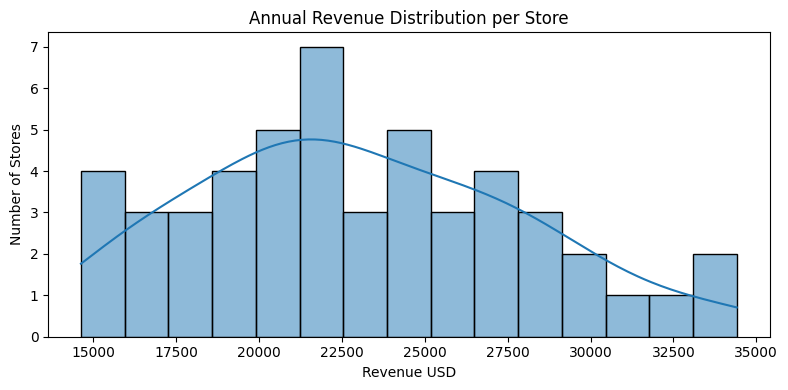

In [6]:
# Cell 6a: revenue histogram
plt.figure(figsize=(8,4))
sns.histplot(annual['total_revenue'], bins=15, kde=True)
plt.title('Annual Revenue Distribution per Store')
plt.xlabel('Revenue USD')
plt.ylabel('Number of Stores')
plt.tight_layout()
plt.show()

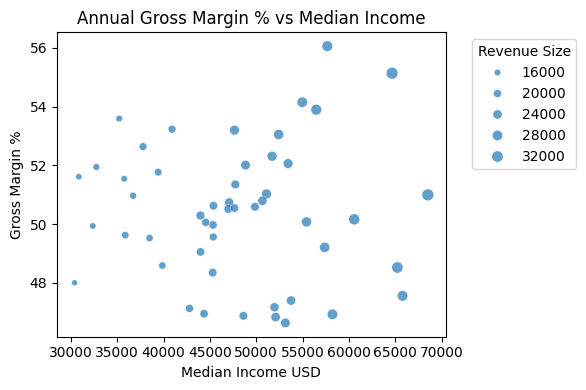

In [7]:
# Cell 6b: margins vs median income
plt.figure(figsize=(6,4))
sns.scatterplot(data=annual, x='median_income', y='annual_margin_pct', size='total_revenue', alpha=0.7)
plt.title('Annual Gross Margin % vs Median Income')
plt.xlabel('Median Income USD')
plt.ylabel('Gross Margin %')
plt.legend(title='Revenue Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

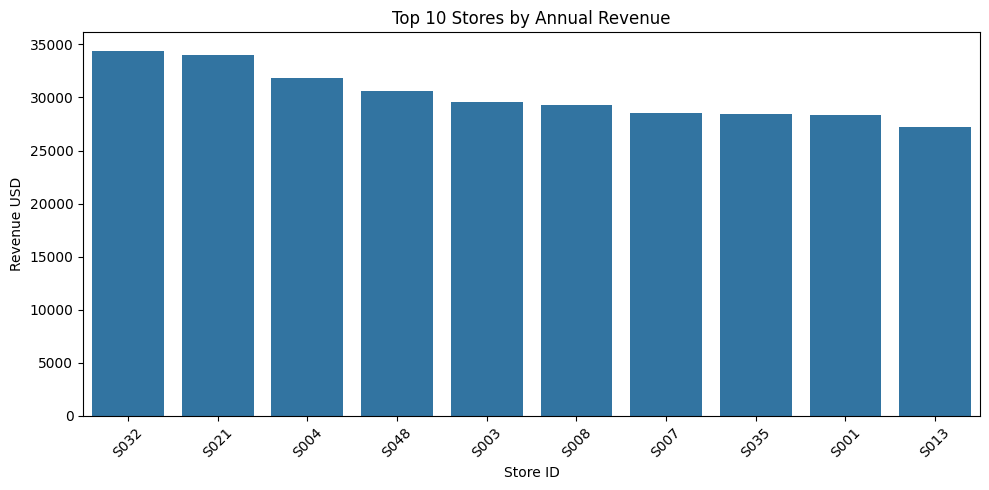

In [8]:
# Cell 6c
top10 = annual.head(10)
plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='store_id', y='total_revenue')
plt.title('Top 10 Stores by Annual Revenue')
plt.xlabel('Store ID')
plt.ylabel('Revenue USD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Cell 7: define quartile-based tiers
annual['revenue_tier'] = pd.qcut(annual['total_revenue'], q=3, labels=['Low', 'Medium', 'High'])
annual['margin_tier'] = pd.qcut(annual['annual_margin_pct'], q=3, labels=['Low', 'Medium', 'High'])

annual[['store_id', 'total_revenue', 'annual_margin_pct', 'revenue_tier', 'margin_tier']].head(15)

,store_id,total_revenue,annual_margin_pct,revenue_tier,margin_tier
31,S032,34411.23,51.00,High,Medium
20,S021,33968.37,55.13,High,High
3,S004,31855.30,48.53,High,Low
47,S048,30581.74,50.16,High,Medium
2,S003,29552.78,53.89,High,High
7,S008,29310.58,56.05,High,High
6,S007,28547.09,47.56,High,Low
34,S035,28461.23,46.93,High,Low
0,S001,28304.06,54.15,High,High
12,S013,27238.51,53.05,High,High


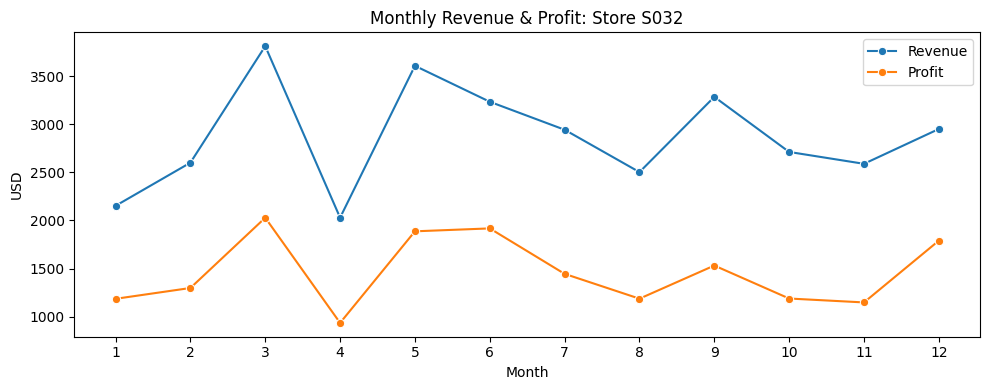

In [10]:
# Cell 8: pick a store to examine
store_to_view = annual.iloc[0]['store_id']  # top revenue store, for example
store_monthly = df[df['store_id'] == store_to_view].sort_values(['year', 'month'])

plt.figure(figsize=(10,4))
sns.lineplot(data=store_monthly, x='month', y='revenue_usd', marker='o', label='Revenue')
sns.lineplot(data=store_monthly, x='month', y='gross_profit_usd', marker='o', label='Profit')
plt.title(f'Monthly Revenue & Profit: Store {store_to_view}')
plt.xlabel('Month')
plt.ylabel('USD')
plt.xticks(store_monthly['month'])
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Cell 9: export to CSV
df.to_csv('synthetic_store_sales_data.csv', index=False)
annual.to_csv('synthetic_annual_summary.csv', index=False)